In [1]:
%load_ext lab_black

In [2]:
import aiohttp
import asyncio

from dataclasses import dataclass

from typing import Iterator, Optional


@dataclass
class Wikidata:
    json: dict
    records: list[dict]

    def __hash__(self) -> int:
        return int(self.json["title"][1:])

    def __repr__(self) -> str:
        return self.name

    def __rich_repr__(self):
        yield self.json["title"]
        yield "name", self.name
        yield "birth", self.birth, None
        yield "death", self.death, None
        if elt := next(self.father, None):
            yield "father", elt.name
        if elt := next(self.mother, None):
            yield "mother", elt.name
        yield "children", list(elt.name for elt in self.children if elt is not None)

    @property
    def name(self) -> str:
        try:
            return self.json["labels"]["en"]["value"]
        except KeyError:
            return self.json["title"]

    @property
    def birth(self) -> Optional[str]:
        entry = self.json["claims"].get("P569")
        if entry is None or len(entry) == 0:
            return None
        date = entry[0]["mainsnak"]["datavalue"]["value"]["time"]
        if date.startswith("+"):
            date = date[1:]
        return date[:4]

    @property
    def death(self) -> Optional[str]:
        entry = self.json["claims"].get("P570")
        if entry is None or len(entry) == 0:
            return None
        date = entry[0]["mainsnak"]["datavalue"]["value"]["time"]
        if date.startswith("+"):
            date = date[1:]
        return date[:4]

    @property
    def father(self) -> Iterator["Wikidata"]:
        for elt in self.json["claims"].get("P22", []):
            id_ = elt["mainsnak"]["datavalue"]["value"]["id"]
            if father := self.records.get(id_, None):
                yield father

    @property
    def mother(self) -> Iterator["Wikidata"]:
        for elt in self.json["claims"].get("P25", []):
            id_ = elt["mainsnak"]["datavalue"]["value"]["id"]
            if mother := self.records.get(id_, None):
                yield mother

    @property
    def children(self) -> Iterator["Wikidata"]:
        for elt in self.json["claims"].get("P40", []):
            id_ = elt["mainsnak"]["datavalue"]["value"]["id"]
            if child := self.records.get(id_, None):
                yield child


async def webcrawl(
    session: aiohttp.ClientSession,
    element: str,
    target: str,
    records: dict,
) -> set[tuple[str, str]]:
    if element in records:
        return set()

    async with session.get(
        f"https://www.wikidata.org/wiki/Special:EntityData/{element}.json",
        proxy="http://localhost:8123",
    ) as response:
        assert response.status == 200
        json = await response.json()

    elt = json["entities"][element]
    records[element] = Wikidata(elt, records)

    if target in records:
        return set()

    father = elt["claims"].get("P22", [])
    mother = elt["claims"].get("P25", [])
    children = elt["claims"].get("P40", [])

    ids = set()
    for c in father + mother + children:
        try:
            ids.add(c["mainsnak"]["datavalue"]["value"]["id"])
        except KeyError:
            pass

    return ids


async def wikidata(
    current: str = "Q9439",  # Queen Victoria
    target: str = "Q9682",  # Queen Elizabeth II
) -> dict[str, dict]:
    records = dict()

    async with aiohttp.ClientSession() as session:
        todo = await webcrawl(session, current, target, records)

        while target not in records.keys():
            output = await asyncio.gather(
                *[webcrawl(session, elt, target, records) for elt in todo]
            )
            todo = set.union(*output) - set(records.keys())

    return records


records = await wikidata()

In [3]:
from rich.pretty import pprint

pprint(records["Q9682"])

Wikidata('Q9682', name='Elizabeth II', birth='1926', father='George VI', children=[])

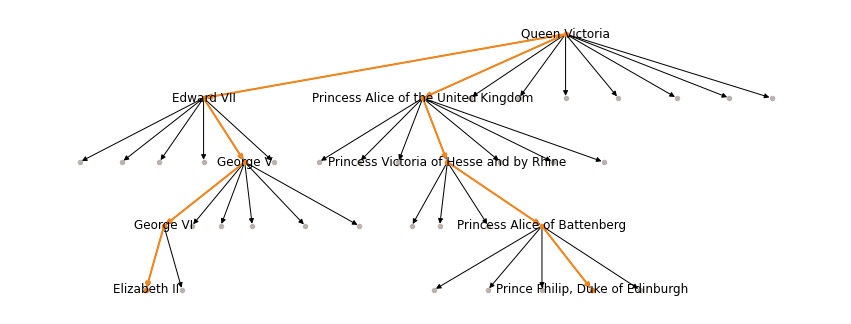

In [4]:
from networkx.drawing.nx_agraph import graphviz_layout  # requires pygraphviz
import networkx as nx

g = nx.DiGraph(list((x, y) for x in records.values() for y in list(x.children)))
path = nx.dijkstra_path(nx.Graph(g), records["Q9682"], records["Q80976"])

subg = g.subgraph(set(y for x in path for y in list(x.children) + [x]))
pos = graphviz_layout(subg, "dot")

fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(aspect=7))
nx.draw(subg, pos, ax=ax, node_size=20, node_color="#bab0ac")
nx.draw(
    g.subgraph(path),
    pos,
    ax=ax,
    with_labels=True,
    node_color="#f58519",
    node_size=20,
    edge_color="#f58518",
    width=2,
)

In [5]:
records = await wikidata("Q9439", "Q151305")  # Christian IX

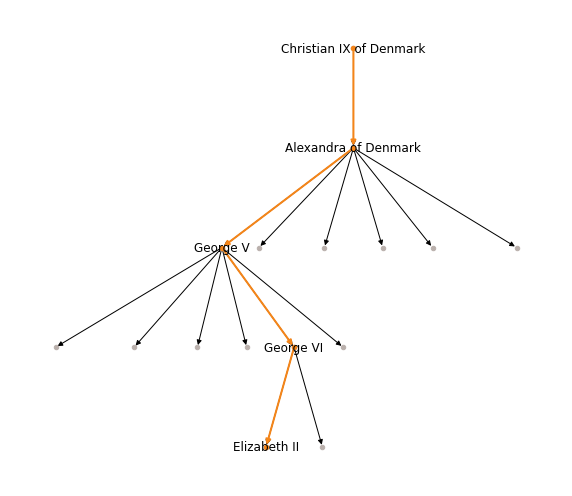

In [6]:
from networkx.drawing.nx_agraph import graphviz_layout  # requires pygraphviz
import networkx as nx

g = nx.DiGraph(list((x, y) for x in records.values() for y in list(x.children)))
path = nx.dijkstra_path(nx.Graph(g), records["Q9682"], records["Q151305"])

subg = g.subgraph(set(y for x in path for y in list(x.children) + [x]))
pos = graphviz_layout(subg, "dot")

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect=7))
nx.draw(subg, pos, ax=ax, node_size=20, node_color="#bab0ac")
nx.draw(
    g.subgraph(path),
    pos,
    ax=ax,
    with_labels=True,
    node_color="#f58519",
    node_size=20,
    edge_color="#f58518",
    width=2,
)

In [7]:
records = await wikidata("Q151305", "Q191045")

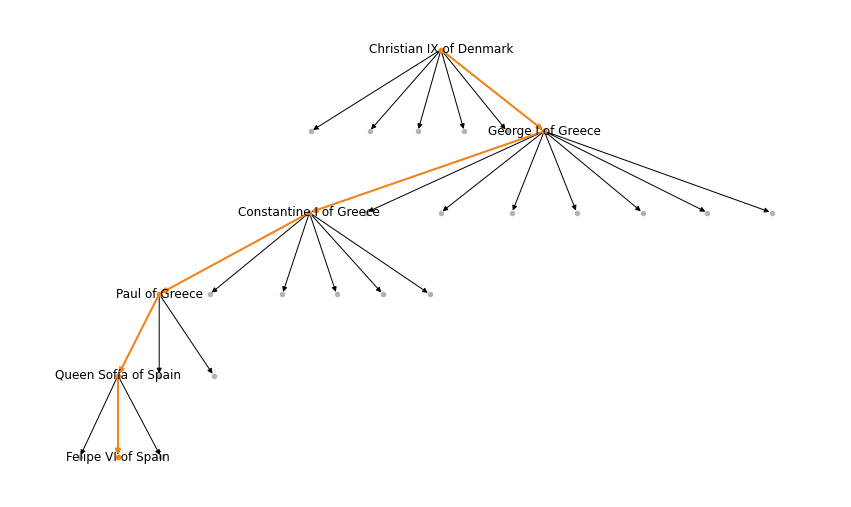

In [8]:
from networkx.drawing.nx_agraph import graphviz_layout  # requires pygraphviz
import networkx as nx

g = nx.DiGraph(list((x, y) for x in records.values() for y in list(x.children)))
path = nx.dijkstra_path(nx.Graph(g), records["Q151305"], records["Q191045"])

subg = g.subgraph(set(y for x in path for y in list(x.children) + [x]))
pos = graphviz_layout(subg, "dot")

fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(aspect=7))
nx.draw(subg, pos, ax=ax, node_size=20, node_color="#bab0ac")
nx.draw(
    g.subgraph(path),
    pos,
    ax=ax,
    with_labels=True,
    node_color="#f58519",
    node_size=20,
    edge_color="#f58518",
    width=2,
)